# Evaluating Tikhonet Trained with Only Euclid PSF

In this Notebook we are going to evaluate the performance of a [Tikhonet](https://arxiv.org/pdf/1911.00443.pdf) trained using only Euclid PSF.

## Required Libraries and Functions

In [1]:
%matplotlib inline
import sys

# Add library path to PYTHONPATH
lib_path = '/gpfswork/rech/xdy/uze68md/GitHub/'
path_alphatransform = lib_path+'alpha-transform'
path_score = lib_path+'score'
sys.path.insert(0, path_alphatransform)
sys.path.insert(0, path_score)

# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import fft
import cadmos_lib as cl
import tensorflow as tf
import galsim
from galsim import Image
import galsim.hsm
import galflow as gf
from galaxy2galaxy import problems

# Functions

def ir2tf_simplifie(imp_resp, shape):
    

    dim = 2
    # Zero padding and fill
    irpadded = np.zeros(shape)
    irpadded[tuple([slice(0, s) for s in imp_resp.shape])] = imp_resp
    # Roll for zero convention of the fft to avoid the phase
    # problem. Work with odd and even size.
    for axis, axis_size in enumerate(imp_resp.shape):

        irpadded = np.roll(irpadded,
                           shift=-int(np.floor(axis_size / 2)),
                           axis=axis)

    return fft.rfftn(irpadded, axes=range(-dim, 0))

def laplacian_simplifie(shape):
    
    impr = np.zeros([3,3])
    for dim in range(2):
        idx = tuple([slice(1, 2)] * dim +
                    [slice(None)] +
                    [slice(1, 2)] * (1 - dim))
        impr[idx] = np.array([-1.0,
                              0.0,
                              -1.0]).reshape([-1 if i == dim else 1
                                              for i in range(2)])
    impr[(slice(1, 2), ) * 2] = 4.0
    return ir2tf_simplifie(impr, shape), impr

def laplacian_tf(shape):
    return tf.convert_to_tensor(laplacian_simplifie(shape)[0])

def wiener_tf(image, psf, balance):
    reg = laplacian_tf(image.shape)
    if psf.shape != reg.shape:
        trans_func = tf.signal.rfft2d(tf.signal.ifftshift(tf.cast(psf, 'float32')))
    else:
        trans_func = psf
    
    arg1 = tf.cast(tf.math.conj(trans_func), 'complex64')
    arg2 = tf.dtypes.cast(tf.math.abs(trans_func),'complex64') ** 2
    arg3 = balance * tf.dtypes.cast(tf.math.abs(laplacian_tf(image.shape)), 'complex64')**2
    wiener_filter = arg1 / (arg2 + arg3)
    
    #deconv = tf.signal.irfft2d(wiener_filter * tf.signal.rfft2d(tf.cast(image, 'float32')))
    wiener_applied = wiener_filter * tf.signal.rfft2d(tf.cast(image, 'float32'))
    
    #deconv = tf.keras.backend.clip(deconv, -1, 1)
    
    return wiener_applied, trans_func

def pre_proc_unet(dico):
    r"""Preprocess the data and apply the Tikhonov filter on the input galaxy images.

    This function takes the dictionnary of galaxy images and PSF for the input and
    the target and returns a list containing 2 arrays: an array of galaxy images that
    are the output of the Tikhonov filter and an array of target galaxy images.

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 2 arrays: an array of galaxy images that are the output of the
        Tikhonov filter and an array of target galaxy images.
    
    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
    x_interpolant=tf.image.ResizeMethod.BICUBIC
    # First, we interpolate the image on a finer grid
    interp_factor = 2
    Nx = 64
    Ny = 64
    dico['inputs_cfht'] = tf.image.resize(dico['inputs'],
                    [Nx*interp_factor,
                    Ny*interp_factor],
                    method=x_interpolant)
    # Since we lower the resolution of the image, we also scale the flux
    # accordingly
    dico['inputs_cfht'] = dico['inputs_cfht'] / interp_factor**2
    
    balance = 10**(-2.16)  #best after grid search
    dico['psf_inputs'] = dico['psf_cfht']
    dico['inputs_tikho'], dico['psf_cfht'] = wiener_tf(dico['inputs_cfht'][...,0], dico['psf_cfht'][...,0], balance)
    dico['inputs_tikho'] = tf.expand_dims(dico['inputs_tikho'], axis=0)
    dico['psf_cfht'] = tf.expand_dims(tf.cast(dico['psf_cfht'], 'complex64'), axis=0)
    dico['inputs_tikho'] = gf.kconvolve(dico['inputs_tikho'], dico['psf_cfht'],zero_padding_factor=1,interp_factor=interp_factor)
    dico['inputs_tikho'] = dico['inputs_tikho'][0,...]
    
    return dico

## Generate The Evaluation Dataset

In [2]:
# Let's create an instance of the hsc_problem
Modes = tf.estimator.ModeKeys
problem128 = problems.problem('attrs2img_cosmos_cfht2hst')
dset = problem128.dataset(Modes.EVAL, data_dir='/gpfswork/rech/xdy/uze68md/data/attrs2img_cosmos_cfht2hst/')
dset = dset.repeat()
dset = dset.map(pre_proc_unet)

n_batch = 128

dset = dset.batch(n_batch)


INFO:tensorflow:Reading data files from /gpfswork/rech/xdy/uze68md/data/attrs2img_cosmos_cfht2hst/attrs2img_cosmos_cfht2hst-dev*
INFO:tensorflow:partition: 0 num_data_files: 3

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Extract Batches and Concatenate Them

In [3]:
# Build an iterator over the dataset
iterator = dset.make_one_shot_iterator().get_next()
sess = tf.Session()

# Initialize batch
batch = sess.run(iterator)
k_batch = 16

for k in range(k_batch-1):
    # Extract temporary batch
    tmp = sess.run(iterator)
    # Add to batch
    for key in tmp:
        batch[key]=np.concatenate((batch[key],tmp[key]))
sess.close()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


## Load and Apply Trained Model on Batch

In [4]:
model_name = 'tikhonet_None-constraint_scales-4_steps-625_epochs-10_growth_rate-12_batch_size-128_activationfunction-relu'
model_dir = '/gpfswork/rech/xdy/uze68md/trained_models/model_cfht_noiseless/'
model = tf.keras.models.load_model(model_dir+model_name, compile=False)
res = model(batch['inputs_tikho'])
res_np = tf.keras.backend.eval(res)[...,0]

for key in ['inputs', 'psf_cfht', 'psf_hst', 'targets', 'inputs_cfht', 'psf_inputs', 'inputs_tikho']:
    batch[key] = batch[key][...,0]

# generate the psfs in the spatial domain
psf_hst = np.fft.ifftshift(np.fft.irfft2(batch['psf_hst'][0]))
psf_euclid = np.fft.ifftshift(np.fft.irfft2(batch['psf_inputs'][:,0]))
# make psf tiles
psf_tile_hst = np.repeat(psf_hst[np.newaxis, :, :], k_batch*n_batch, axis=0)
psf_tile_euclid = np.repeat(psf_euclid[np.newaxis, :, :], k_batch*n_batch, axis=0)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Plot Galaxy Images

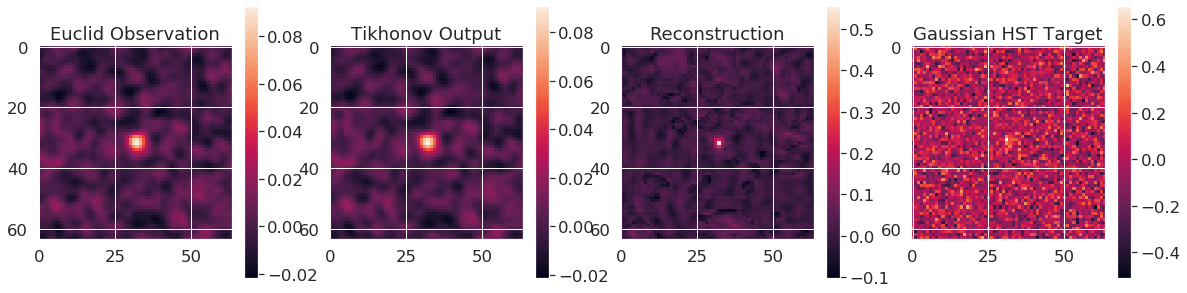

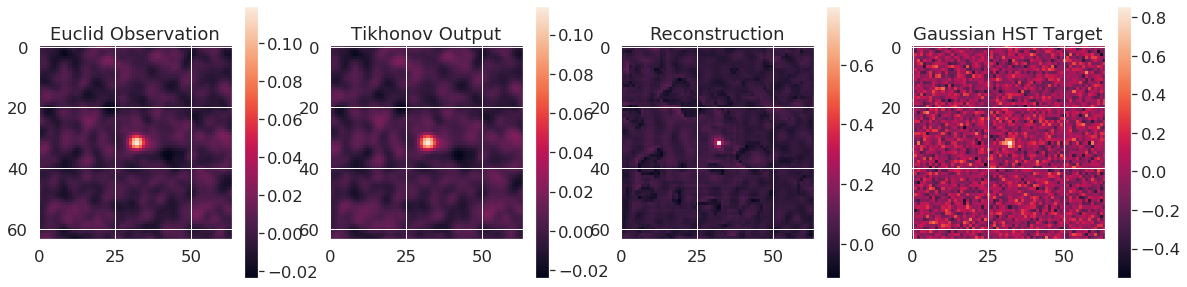

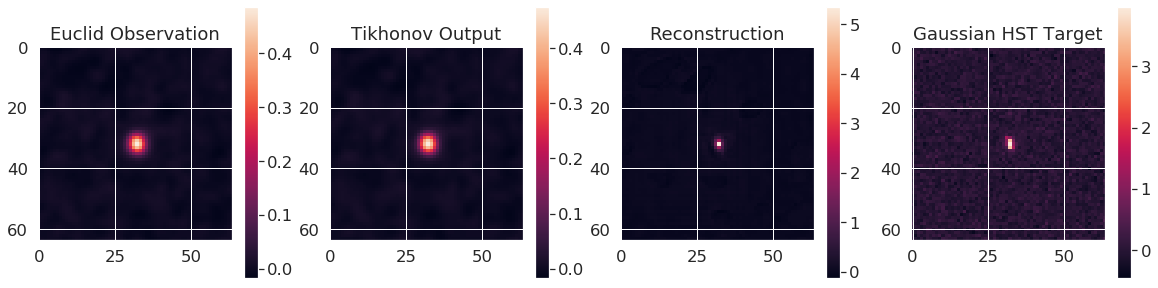

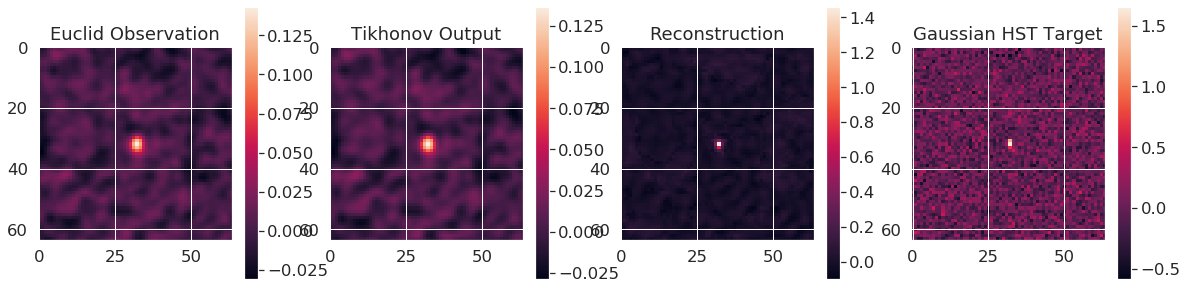

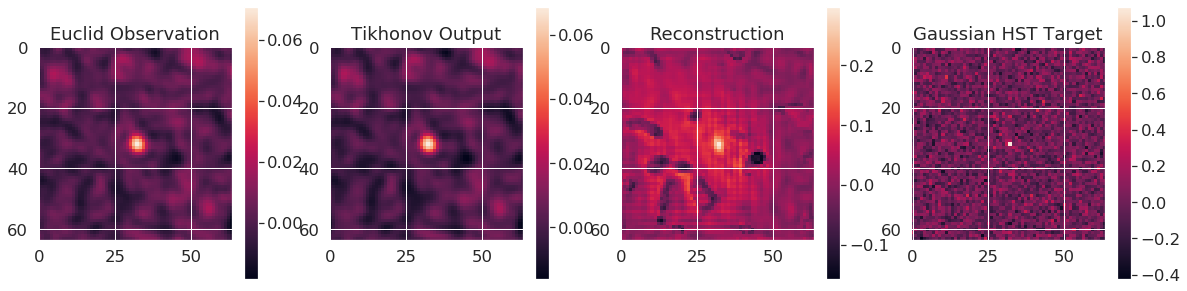

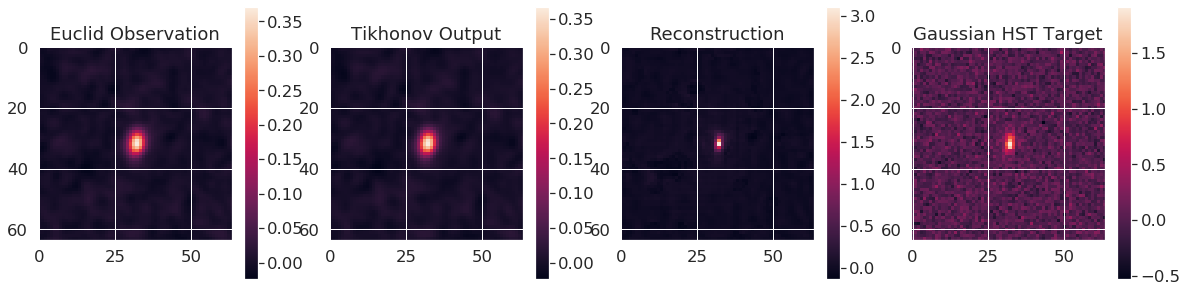

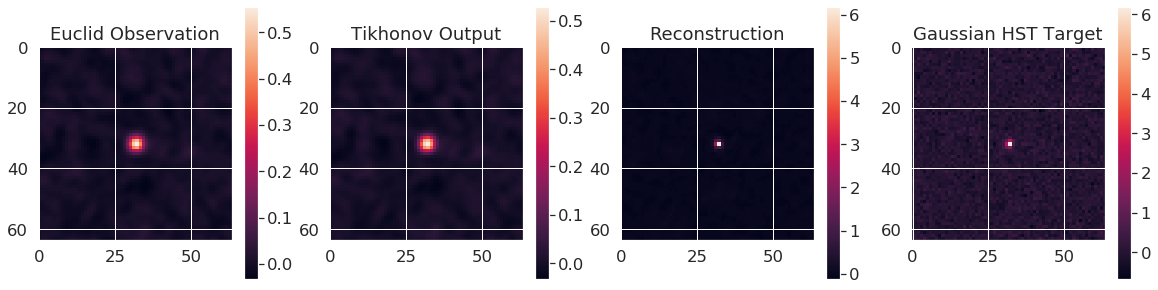

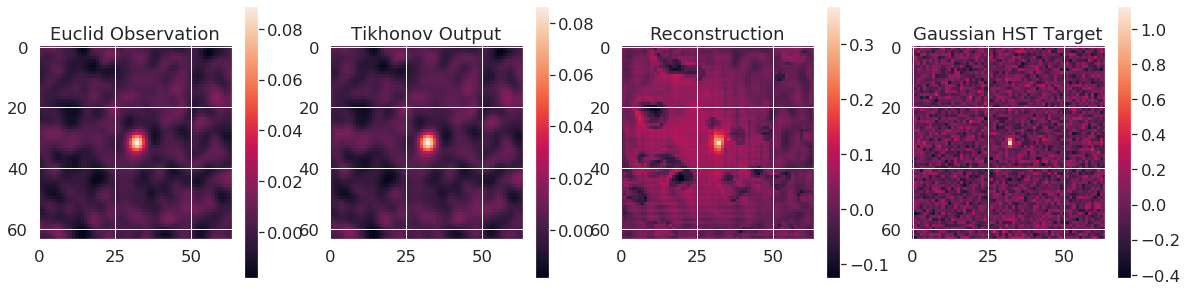

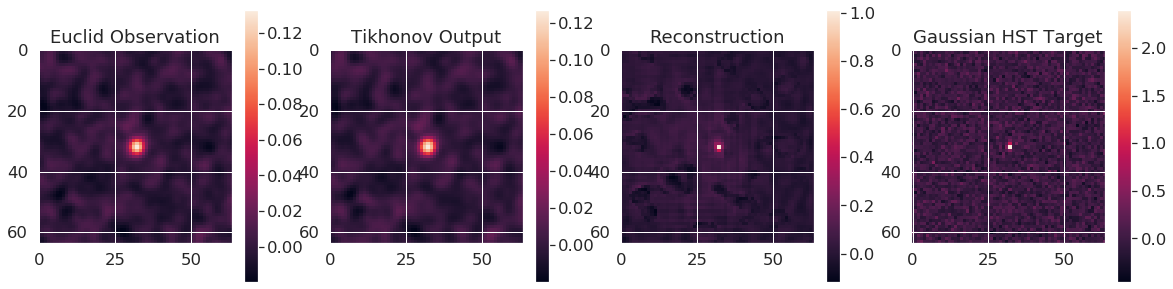

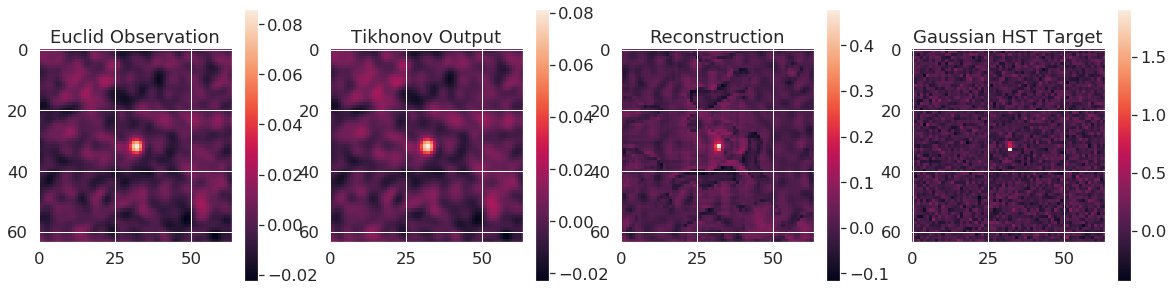

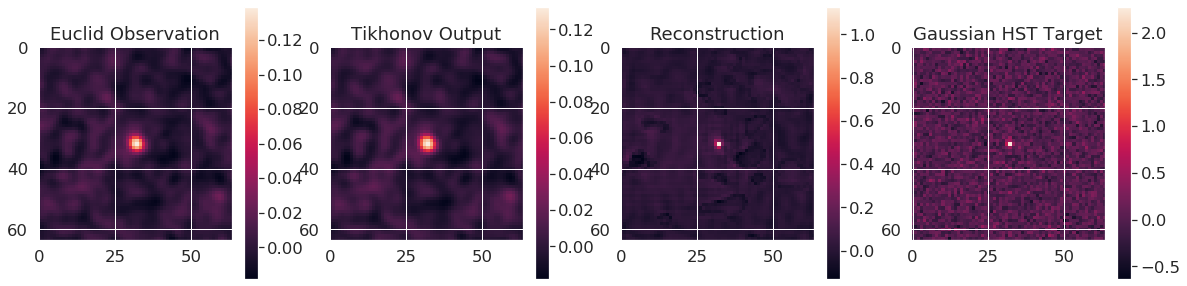

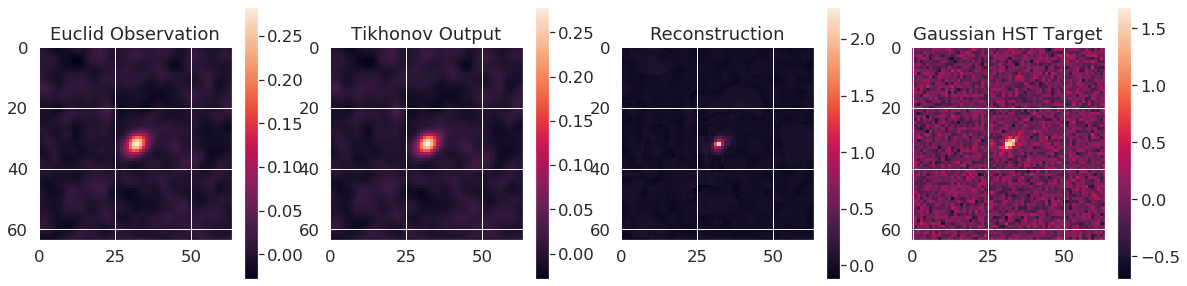

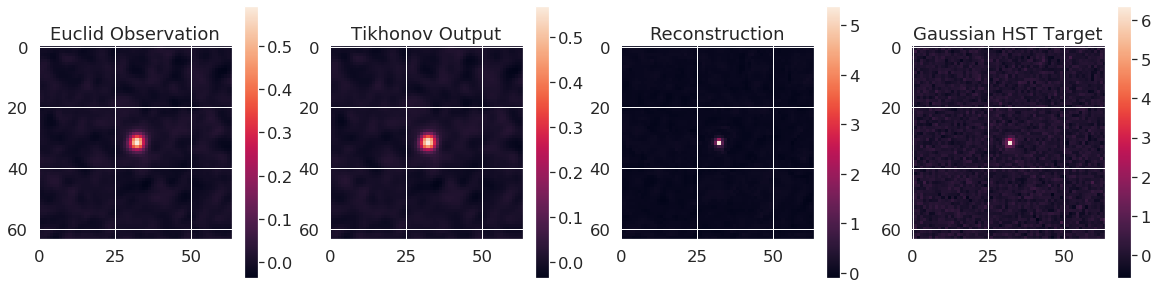

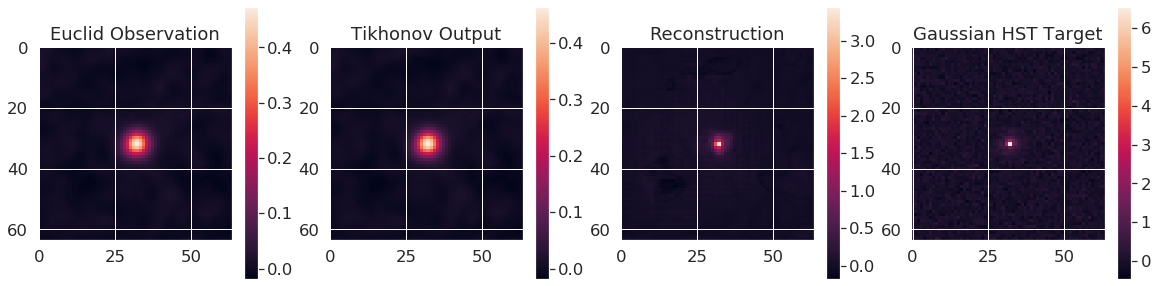

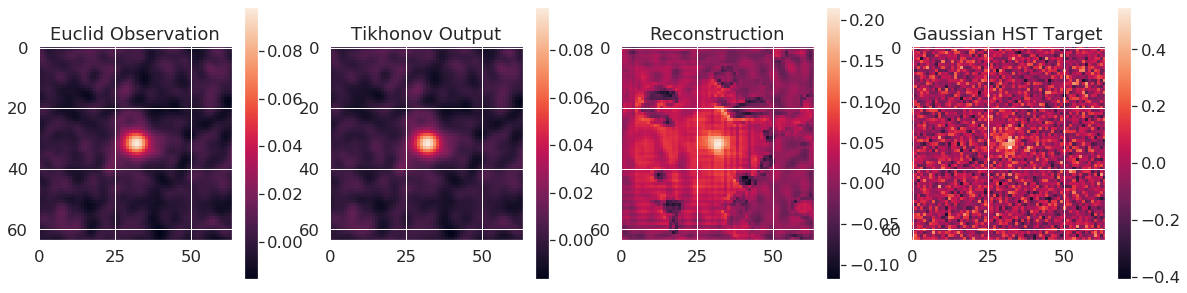

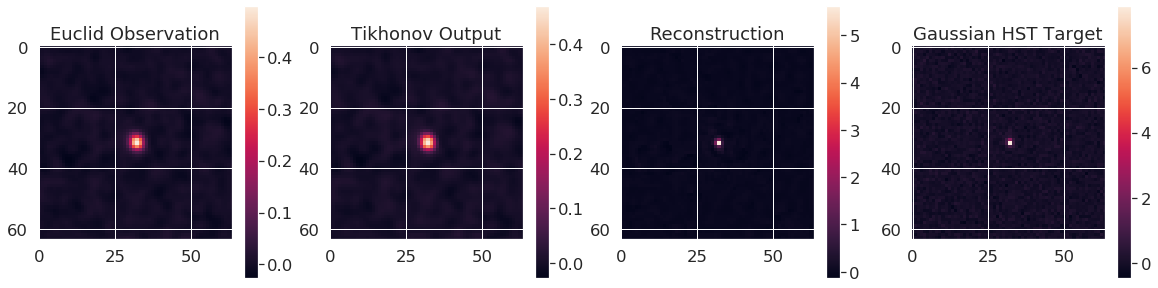

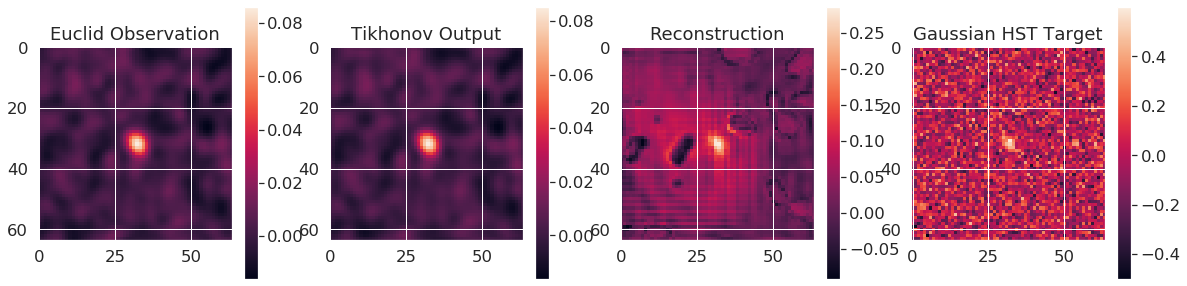

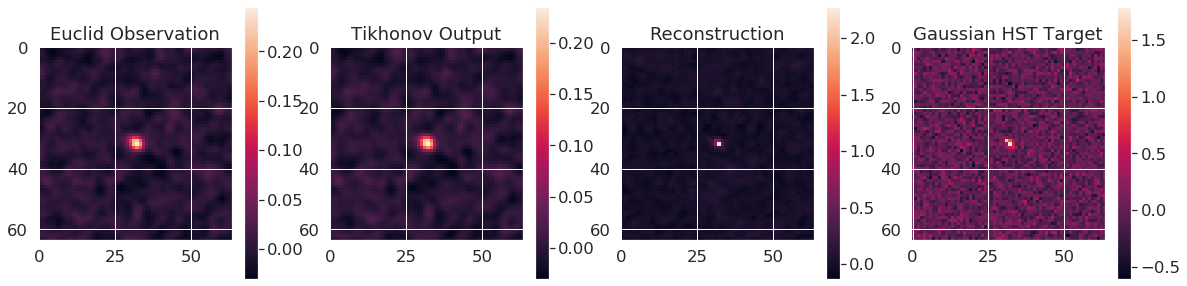

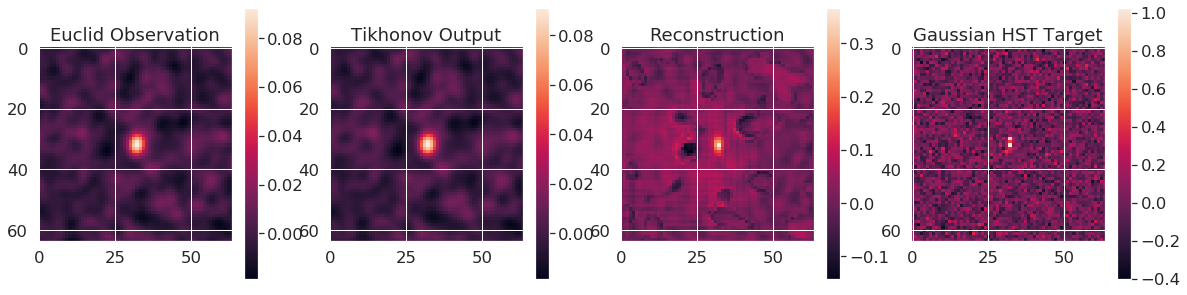

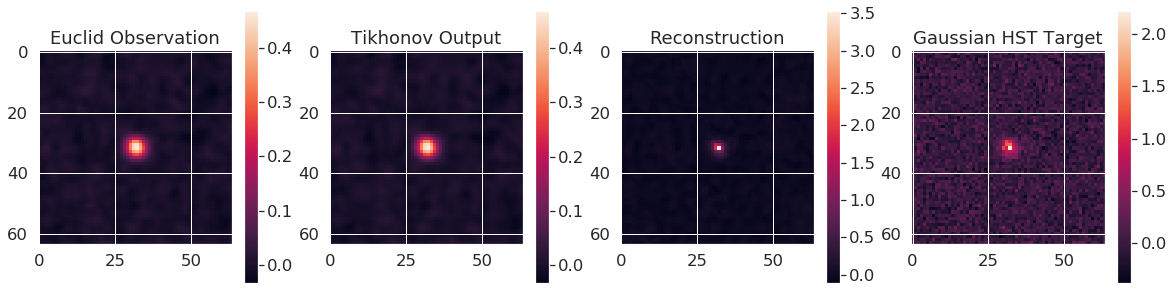

In [5]:
# set seaborn theme and style
sns.set_theme()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

for i in range(20):#n_batch):
    plt.figure(33,figsize=(20,5))
    plt.subplot(141)
    plt.imshow(batch['inputs'][i])
    plt.title('Euclid Observation')
    plt.colorbar()
    plt.subplot(142)
    plt.imshow(batch['inputs_tikho'][i])
    plt.title('Tikhonov Output')
    plt.colorbar()
    plt.subplot(143)
    plt.imshow(res_np[i])
    plt.title('Reconstruction')
    plt.colorbar()
    plt.subplot(144)
    plt.imshow(batch['targets'][i])
    plt.title('Gaussian HST Target')
    plt.colorbar()
    plt.show()

## Processing and Analyzing Results

### Define Error Metrics

In [6]:
U = cl.makeUi(*batch['inputs_tikho'].shape[1:3])
im_size = 64
scale = 0.1

def estimate_ell(img):
    GX = np.array([cl.scal(img,U_i) for U_i in U])
    mu20 = 0.5*(GX[3]+GX[4])-GX[0]**2/GX[2]
    mu02 = 0.5*(GX[3]-GX[4])-GX[1]**2/GX[2]
    mu11 = GX[5]-GX[0]*GX[1]/GX[2]
    e1 = (mu20-mu02)/(mu20+mu02)
    e2 = 2*(mu11)/(mu20+mu02)
    e = np.array([e1,e2])
    return e

def EllipticalGaussian(e1, e2, sig, xc=im_size//2, yc=im_size//2, stamp_size=(im_size,im_size)):
    # compute centered grid
    ranges = np.array([np.arange(i) for i in stamp_size])
    x = np.outer(ranges[0] - xc, np.ones(stamp_size[1]))
    y = np.outer(np.ones(stamp_size[0]),ranges[1] - yc)
    # shift it to match centroid
    xx = (1-e1/2)*x - e2/2*y
    yy = (1+e1/2)*y - e2/2*x
    # compute elliptical gaussian
    return np.exp(-(xx ** 2 + yy ** 2) / (2 * sig ** 2))

def relative_mse(solution, ground_truth):
    relative_mse = ((solution-ground_truth)**2).mean()/ \
                         (ground_truth**2).mean()
    return relative_mse



def get_KSB_ell(image,psf):
    error_flag = True
    #create a galsim version of the data
    image_galsim = Image(image,scale=scale)
    psf_galsim = Image(psf,scale=scale)
    #estimate the moments of the observation image
    ell=galsim.hsm.EstimateShear(image_galsim
                                 ,psf_galsim,shear_est='KSB'
                                 ,guess_centroid=galsim.PositionD(im_size//2,im_size//2)
                                 ,strict=False)
    if ell.error_message != '':
        error_flag = False
    return ell#,error_flag

def get_KSB_g(images,psfs):
    g_list,error_flag_list=[],[]
    for image,psf in zip(images,psfs):
        error_flag = True
        #create a galsim version of the data
        image_galsim = galsim.Image(image,scale=scale)
        # CHECK ADAPTIVE MOMENTS
        psf_galsim = galsim.Image(psf,scale=scale)
        #estimate the moments of the observation image
        shape = galsim.hsm.EstimateShear(image_galsim
                                         ,psf_galsim,shear_est='KSB'
                                         ,guess_centroid=galsim.PositionD(im_size//2,im_size//2)
                                         ,strict=False)
        g = np.array([shape.corrected_g1, shape.corrected_g2])
#        g = np.array([shape.observed_shape.g1, shape.observed_shape.g2])
        if shape.error_message:# or np.linalg.norm(shape.corrected_g1+shape.corrected_g2*1j)>1:
            error_flag = False
        error_flag_list += [error_flag]
        g_list += [g]
    return np.array(g_list).T,np.array(error_flag_list)

def get_moments(images, bool_window=False):
    g_list,error_flag_list=[],[]
    if bool_window:
        window_list = []
    for image in images:
        error_flag = True
        #create a galsim version of the data
        image_galsim = galsim.Image(image,scale=scale)
        #estimate the moments of the observation image
        shape = galsim.hsm.FindAdaptiveMom(image_galsim
                                         ,guess_centroid=galsim.PositionD(im_size//2,im_size//2)
                                         ,strict=False)
        if bool_window:
            k_sigma = 3 #scale up the size of the Gaussian window to make it able to capture more useful signal
            window = EllipticalGaussian(-1.*shape.observed_shape.e1, shape.observed_shape.e2 #convention fix:
                                                                                             #e1 sign swap
                                 ,shape.moments_sigma*k_sigma # convention fix: swap x and y and origin at (0,0)
                                 ,shape.moments_centroid.y-1, shape.moments_centroid.x-1
                                 ,image.shape)
        g = np.array([shape.observed_shape.g1, shape.observed_shape.g2])
        if shape.error_message:# or np.linalg.norm(shape.corrected_g1+shape.corrected_g2*1j)>1:
            error_flag = False
        error_flag_list += [error_flag]
        g_list += [g]
        if bool_window:
            window_list += [window]
    output = [np.array(g_list).T,np.array(error_flag_list)]
    if bool_window:
        output += [np.array([window_list])[0]]
    return output

def g_to_e(g1,g2):
    shear = galsim.Shear(g1=g1,g2=g2)
    ell = -shear.e1, shear.e2 #reverse the signe of e_1 to get our conventions
    return ell

def MSE(X1,X2,norm=False):
    #Computes the relative MSE
    temp = 1
    if norm:
        temp = np.mean(X2**2)
    return np.mean((X1-X2)**2)/temp

def MSE_obj(obj1,obj2,norm=False):
    return np.array([MSE(o1,o2,norm) for o1,o2 in zip(obj1,obj2)])

### Estimate Unwindowed Ellipticities, KSB shear and Adaptive Moments

In [7]:
ell_recon = np.array([estimate_ell(gal) for gal in res_np]).T
ell_euc = np.array([estimate_ell(gal) for gal in batch['inputs']]).T
ell_tikh = np.array([estimate_ell(gal) for gal in batch['inputs_tikho']]).T
ell_hst = np.array([estimate_ell(gal) for gal in batch['targets']]).T

ksb_recon,flags_recon = get_KSB_g(res_np,psf_tile_hst)
ksb_euc,flags_euc = get_KSB_g(batch['inputs'],psf_tile_hst)
ksb_tikh,flags_tikh = get_KSB_g(batch['inputs_tikho'],psf_tile_hst)
ksb_hst,flags_hst = get_KSB_g(batch['targets'],psf_tile_hst)

mom_recon,flags_recon = get_moments(res_np)
mom_euc,flags_euc = get_moments(batch['inputs'])
mom_tikh,flags_tikh = get_moments(batch['inputs_tikho'])
mom_hst,flags_hst,windows = get_moments(batch['targets'],bool_window=True)

flags_all = flags_recon*flags_euc*flags_tikh*flags_hst

### Estimate Moments and Pixel Errors

In [8]:
# compute pixel errors
mse_recon = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_np)])
mse_euc = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], batch['inputs'])])
mse_tikh = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], batch['inputs_tikho'])])

# # compute relative pixel errors
# mse_recon = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_np)])
# mse_euc = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], batch['inputs'])])
# mse_tikh = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], batch['inputs_tikho'])])

# compute winodwed relative pixel errors
mse_recon_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], res_np,windows)])
mse_euc_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], batch['inputs'],windows)])
mse_tikh_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], batch['inputs_tikho'],windows)])

# compute adapative moments error
mom_err_recon = mom_recon-mom_hst
mom_err_euc = mom_euc-mom_hst
mom_err_tikh = mom_tikh-mom_hst

### Compute Errors per Bin

In [9]:
# MAKING MAG BINS
# Binning parameters
n_bins = 5
bin_start = np.min(batch['mag_auto'])
bin_end = np.max(batch['mag_auto'])
bins = np.linspace(bin_start, bin_end, n_bins)
# Applying bins
mag_ind = np.digitize(batch['mag_auto'], bins) # Extracting bin indices
mag_bins = np.take(bins,mag_ind-1) # Creating binned magnitudes array

# computing mean and standard deviation of adapative moments error per binned magnitude

mom_mean_recon = []
mom_mean_tikh = []
mom_mean_euc = []

mom_std_recon = []
mom_std_tikh = []
mom_std_euc =[]

# computing mean and standard deviation of relative mse error per binned magnitude

mse_mean_recon = []
mse_mean_tikh = []
mse_mean_euc = []

mse_std_recon = []
mse_std_tikh = []
mse_std_euc =[]

mse_mean_recon_w = []
mse_mean_tikh_w = []
mse_mean_euc_w = []

mse_std_recon_w = []
mse_std_tikh_w = []
mse_std_euc_w =[]

for val in bins:
    ind = (val == mag_bins)
    mom_mean_recon += [np.mean(np.abs(mom_err_recon[:,ind]),axis=1)]
    mom_mean_tikh += [np.mean(np.abs(mom_err_tikh[:,ind]),axis=1)]
    mom_mean_euc += [np.mean(np.abs(mom_err_euc[:,ind]),axis=1)]

    mom_std_recon += [np.std(np.abs(mom_err_recon[:,ind]),axis=1)]
    mom_std_tikh += [np.std(np.abs(mom_err_tikh[:,ind]),axis=1)]
    mom_std_euc += [np.std(np.abs(mom_err_euc[:,ind]),axis=1)]
    
    mse_mean_recon += [np.mean(mse_recon[ind])]
    mse_mean_tikh += [np.mean(mse_tikh[ind])]
    mse_mean_euc += [np.mean(mse_euc[ind])]

    mse_std_recon += [np.std(mse_recon[ind])]
    mse_std_tikh += [np.std(mse_tikh[ind])]
    mse_std_euc += [np.std(mse_euc[ind])]
    
    mse_mean_recon_w += [np.mean(mse_recon_w[ind])]
    mse_mean_tikh_w += [np.mean(mse_tikh_w[ind])]
    mse_mean_euc_w += [np.mean(mse_euc_w[ind])]

    mse_std_recon_w += [np.std(mse_recon_w[ind])]
    mse_std_tikh_w += [np.std(mse_tikh_w[ind])]
    mse_std_euc_w += [np.std(mse_euc_w[ind])]
    
# Convert to numpy array with shape (2, n_bins)

mom_mean_recon = np.array(mom_mean_recon).T
mom_mean_tikh = np.array(mom_mean_tikh).T
mom_mean_euc = np.array(mom_mean_euc).T

mom_std_recon = np.array(mom_std_recon).T
mom_std_tikh = np.array(mom_std_tikh).T
mom_std_euc = np.array(mom_std_euc).T

mse_mean_recon = np.array(mse_mean_recon).T
mse_mean_tikh = np.array(mse_mean_tikh).T
mse_mean_euc = np.array(mse_mean_euc).T

mse_std_recon = np.array(mse_std_recon).T
mse_std_tikh = np.array(mse_std_tikh).T
mse_std_euc = np.array(mse_std_euc).T

mse_mean_recon_w = np.array(mse_mean_recon_w).T
mse_mean_tikh_w = np.array(mse_mean_tikh_w).T
mse_mean_euc_w = np.array(mse_mean_euc_w).T

mse_std_recon_w = np.array(mse_std_recon_w).T
mse_std_tikh_w = np.array(mse_std_tikh_w).T
mse_std_euc_w = np.array(mse_std_euc_w).T

In [10]:
windows.shape

(2048, 64, 64)

### Compute Errors per Bin

In [11]:
label_tikh = r'Tikhonov'
label_euc = r'Euclid'
label_recon = r'Tikhonet'

color_tikh = 'green'
color_euc = 'blue'
color_recon = 'red'

### Adoptive Moments RMSE vs MAG plot

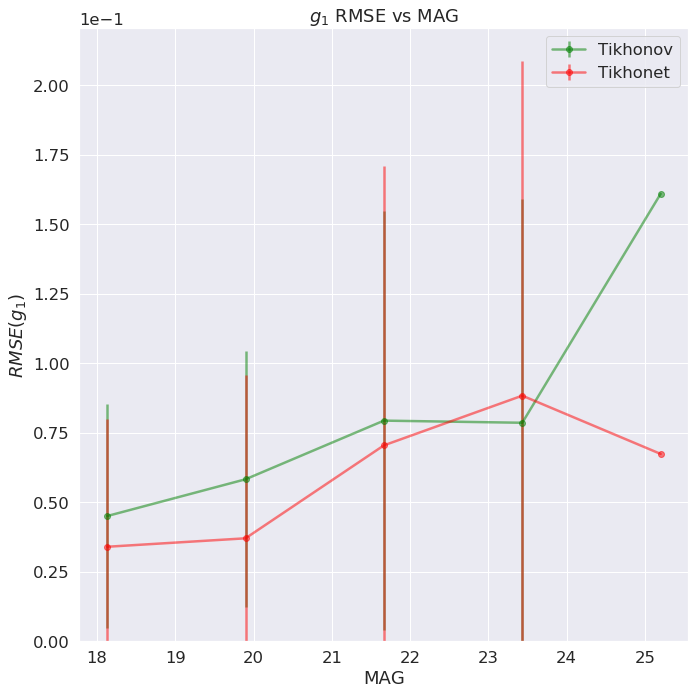

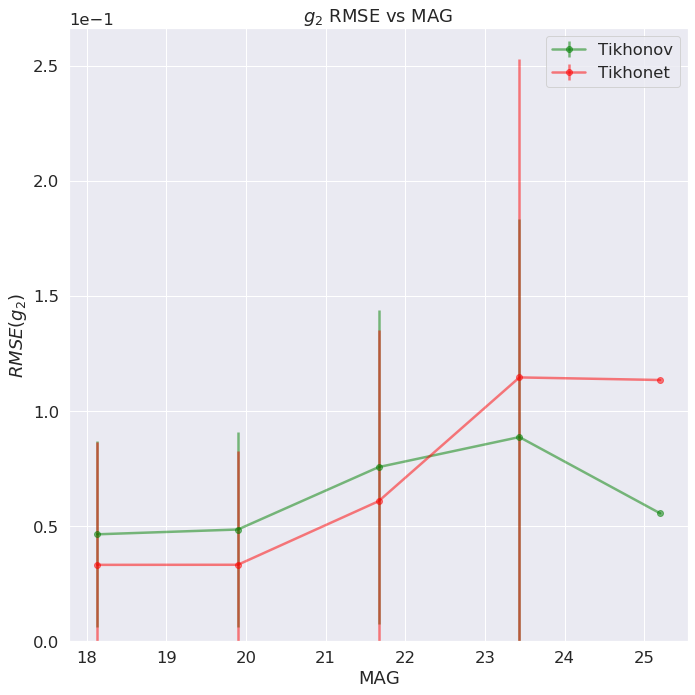

In [12]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_tikh[0],mom_std_tikh[0],linestyle='-', marker='o',color=color_tikh,label=label_tikh,alpha=0.5)
plt.errorbar(bins,mom_mean_recon[0],mom_std_recon[0],linestyle='-', marker='o',color=color_recon,label=label_recon,alpha=0.5)
# plt.errorbar(bins,mom_mean_euc[0],mom_std_euc[0],linestyle='-', marker='o',color=color_euc,label=label_euc)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(g_{1})$')
plt.title(r'$g_1$ RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_tikh[1],mom_std_tikh[1],linestyle='-', marker='o',color=color_tikh,label=label_tikh,alpha=0.5)
plt.errorbar(bins,mom_mean_recon[1],mom_std_recon[1],linestyle='-', marker='o',color=color_recon,label=label_recon,alpha=0.5)
# plt.errorbar(bins,mom_mean_euc[1],mom_std_euc[1],linestyle='-', marker='o',color=color_euc,label=label_euc)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(g_2)$')
plt.title(r'$g_2$ RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

### Pixel Relative MSE vs MAG plot

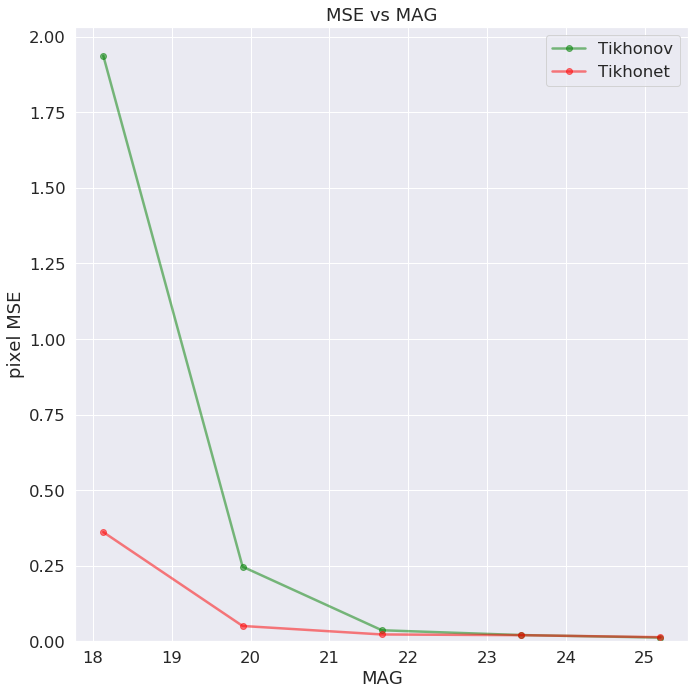

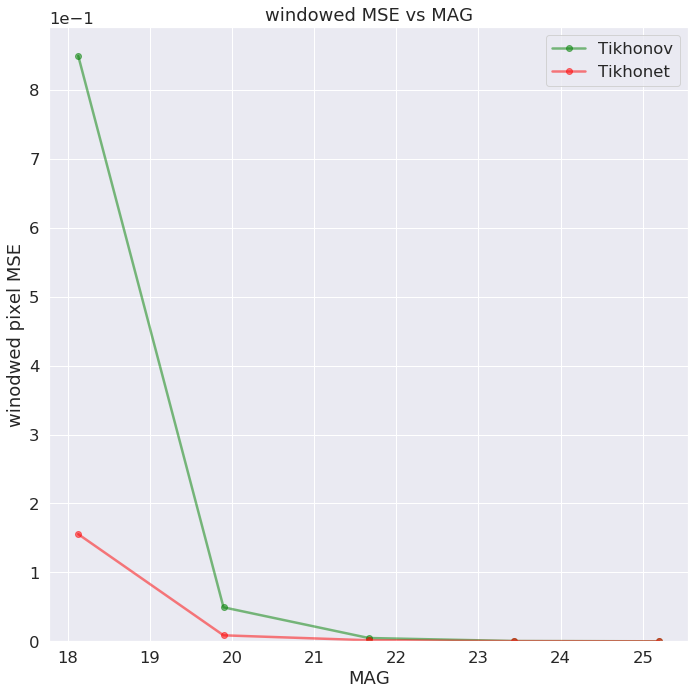

In [13]:
plt.figure(figsize=(10,10))
# plt.errorbar(bins,mse_mean_tikh,mse_std_tikh,linestyle='-', marker='o',color=color_tikh,label=label_tikh,alpha=0.5)
# plt.errorbar(bins,mse_mean_recon,mse_std_recon,linestyle='-', marker='o',color=color_recon,label=label_recon,alpha=0.5)
# plt.errorbar(bins,mse_mean_euc,mse_std_euc,linestyle='-', marker='o',color=color_euc,label=label_euc,alpha=0.5)
plt.plot(bins,mse_mean_tikh,linestyle='-', marker='o',color=color_tikh,label=label_tikh,alpha=0.5)
plt.plot(bins,mse_mean_recon,linestyle='-', marker='o',color=color_recon,label=label_recon,alpha=0.5)
#plt.plot(bins,mse_mean_euc,linestyle='-', marker='o',color=color_euc,label=label_euc,alpha=0.5)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'pixel MSE')
plt.title(r'MSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
# plt.errorbar(bins,mse_mean_tikh,mse_std_tikh,linestyle='-', marker='o',color=color_tikh,label=label_tikh,alpha=0.5)
# plt.errorbar(bins,mse_mean_recon,mse_std_recon,linestyle='-', marker='o',color=color_recon,label=label_recon,alpha=0.5)
# plt.errorbar(bins,mse_mean_euc,mse_std_euc,linestyle='-', marker='o',color=color_euc,label=label_euc,alpha=0.5)
plt.plot(bins,mse_mean_tikh_w,linestyle='-', marker='o',color=color_tikh,label=label_tikh,alpha=0.5)
plt.plot(bins,mse_mean_recon_w,linestyle='-', marker='o',color=color_recon,label=label_recon,alpha=0.5)
#plt.plot(bins,mse_mean_euc,linestyle='-', marker='o',color=color_euc,label=label_euc,alpha=0.5)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'winodwed pixel MSE')
plt.title(r'windowed MSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

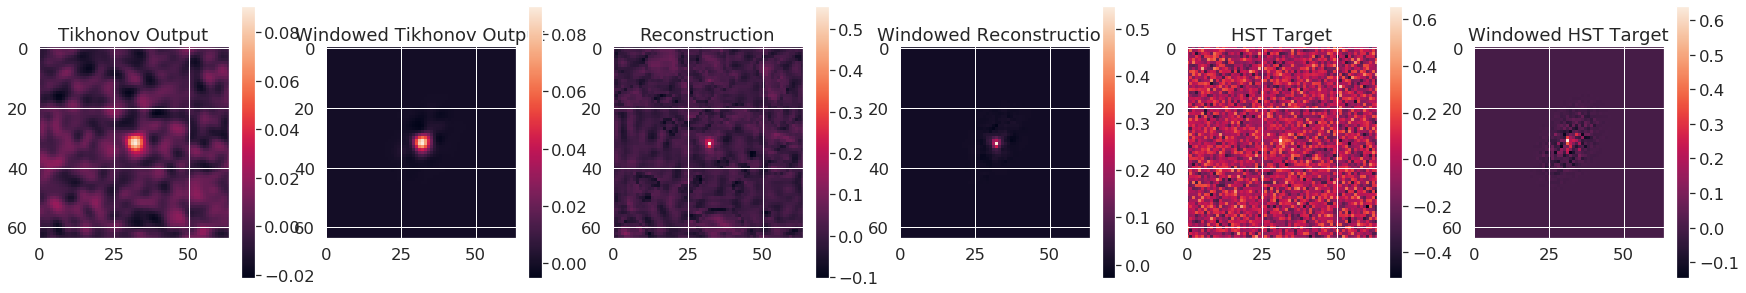

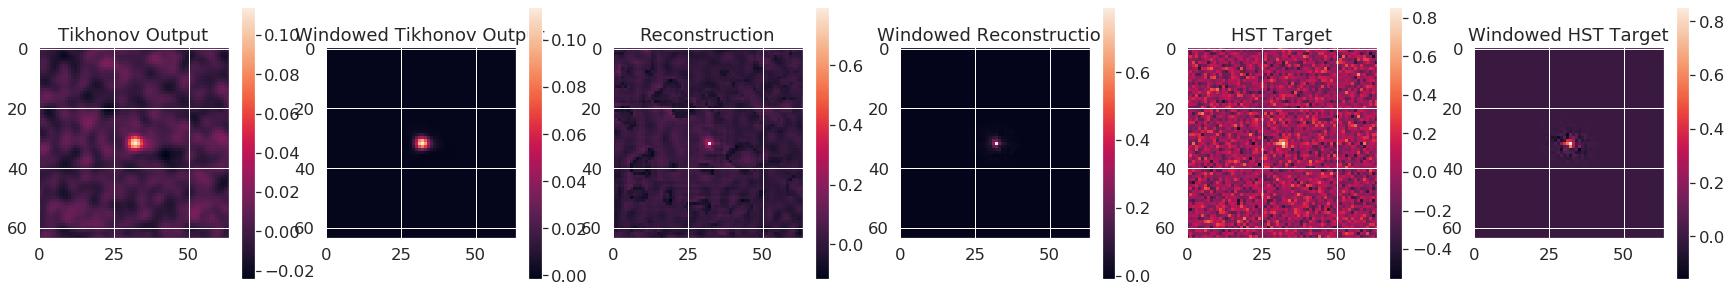

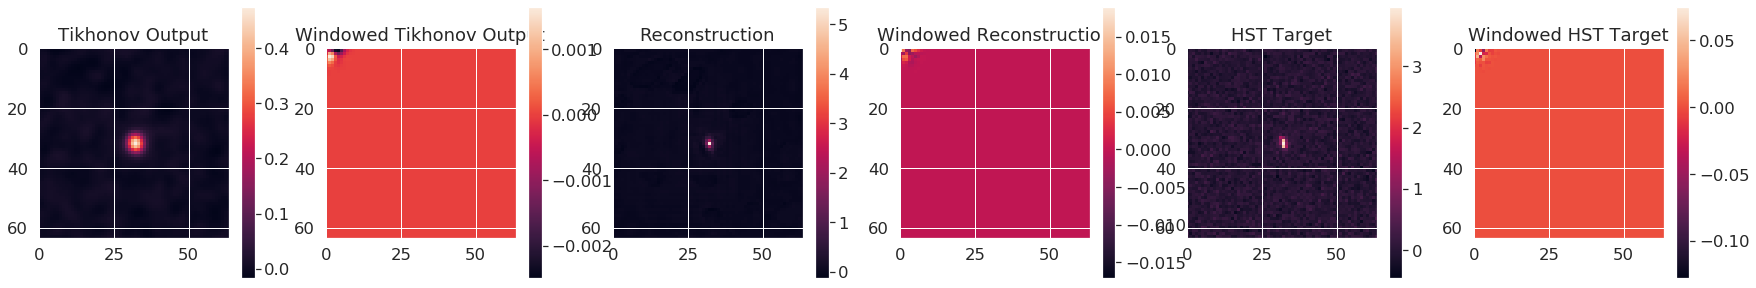

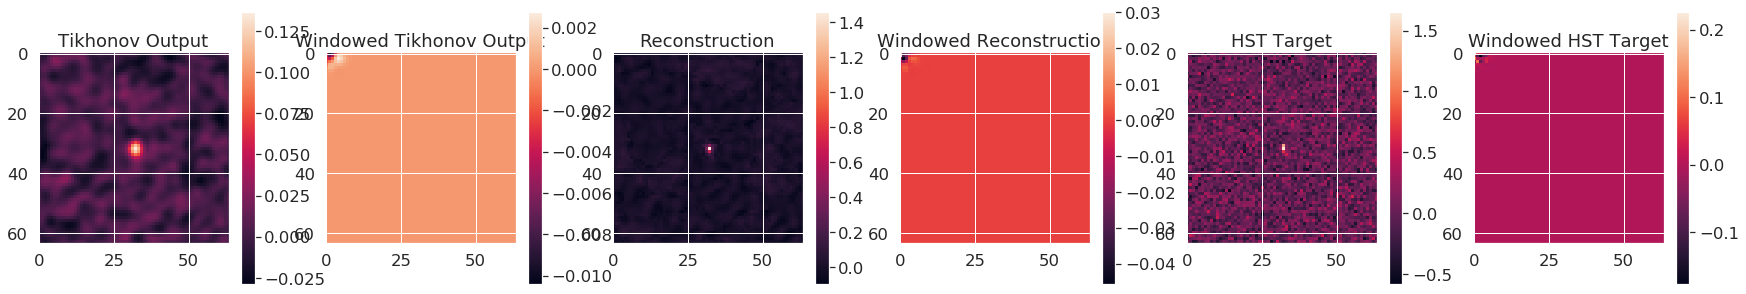

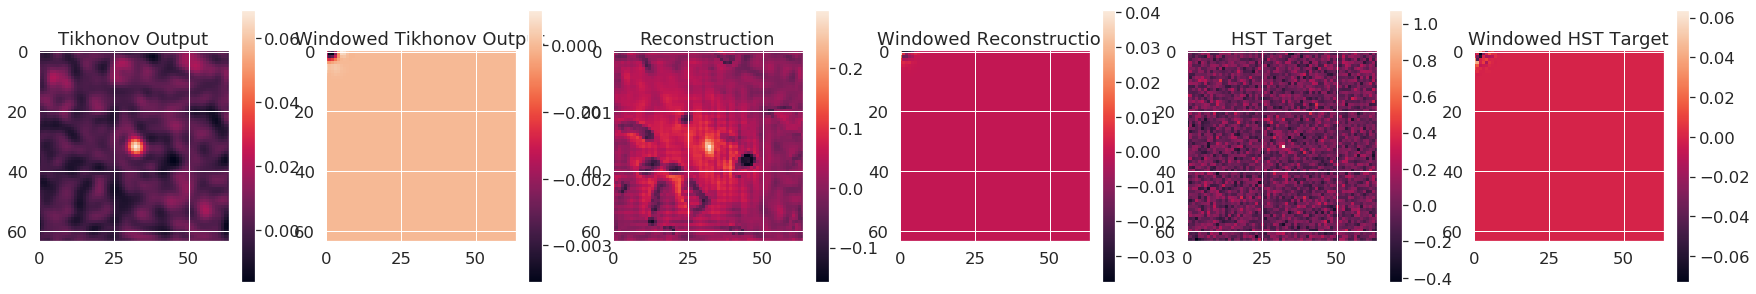

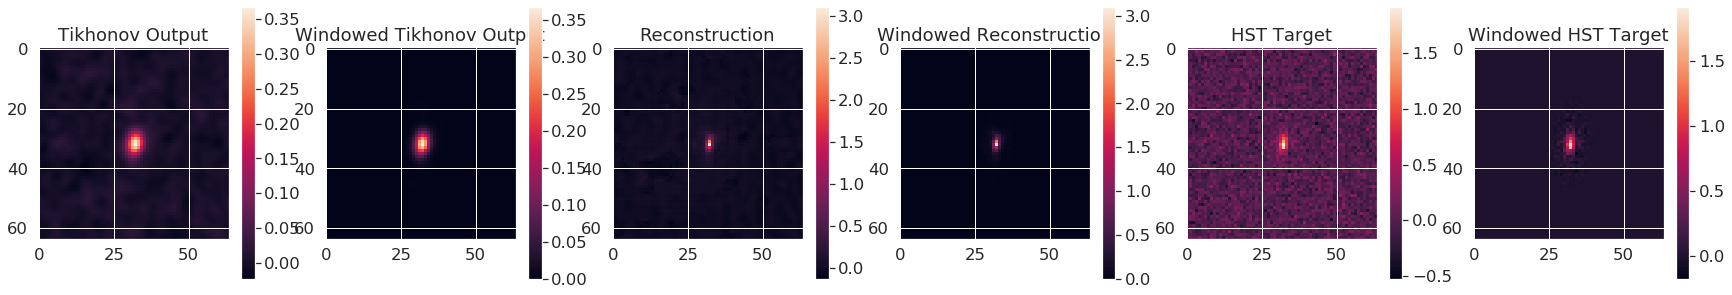

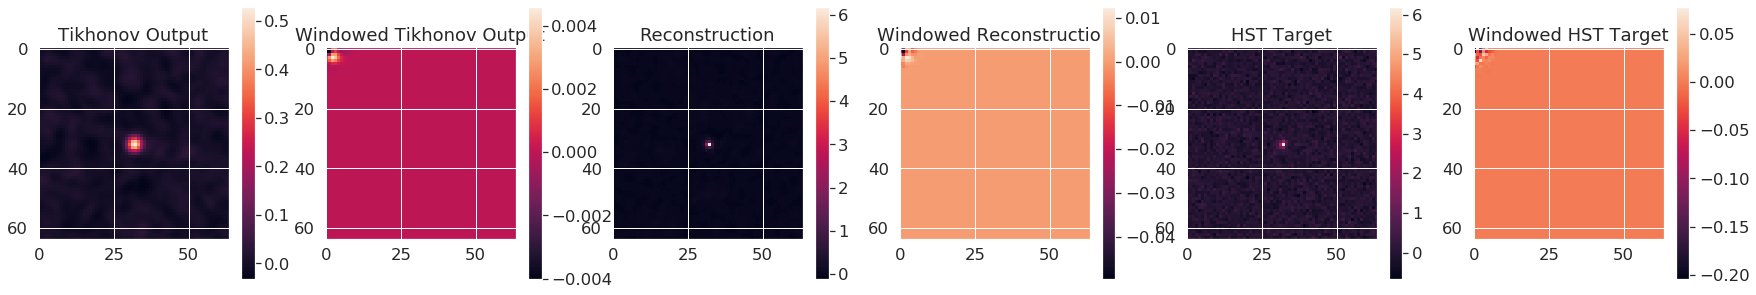

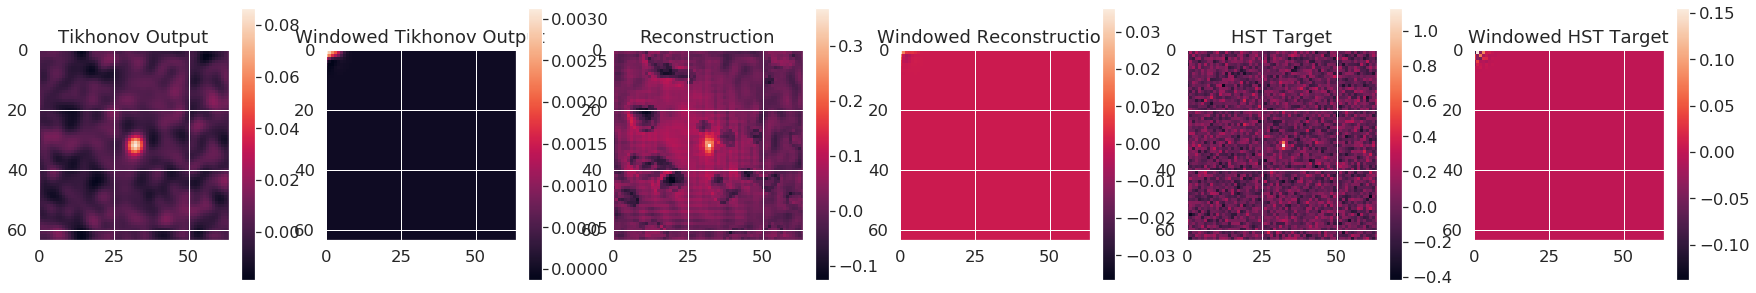

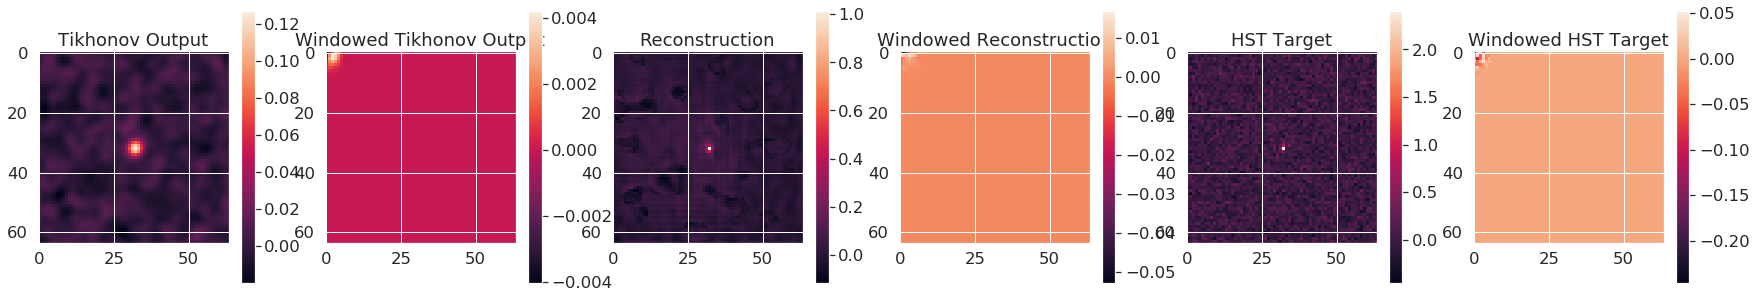

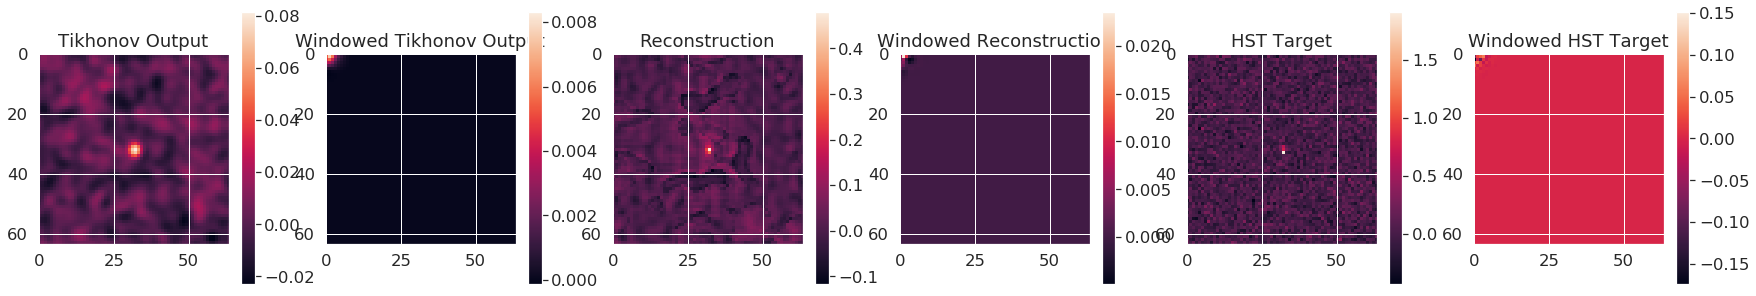

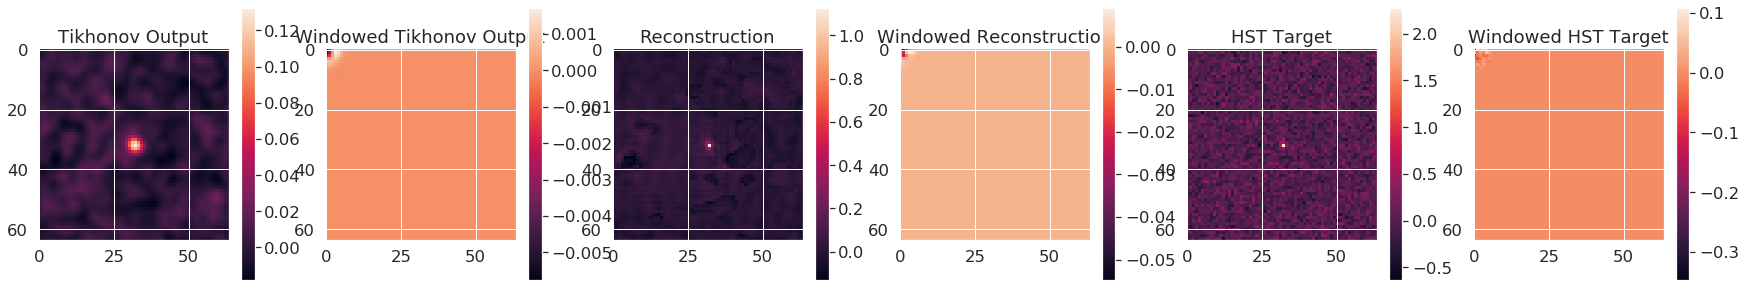

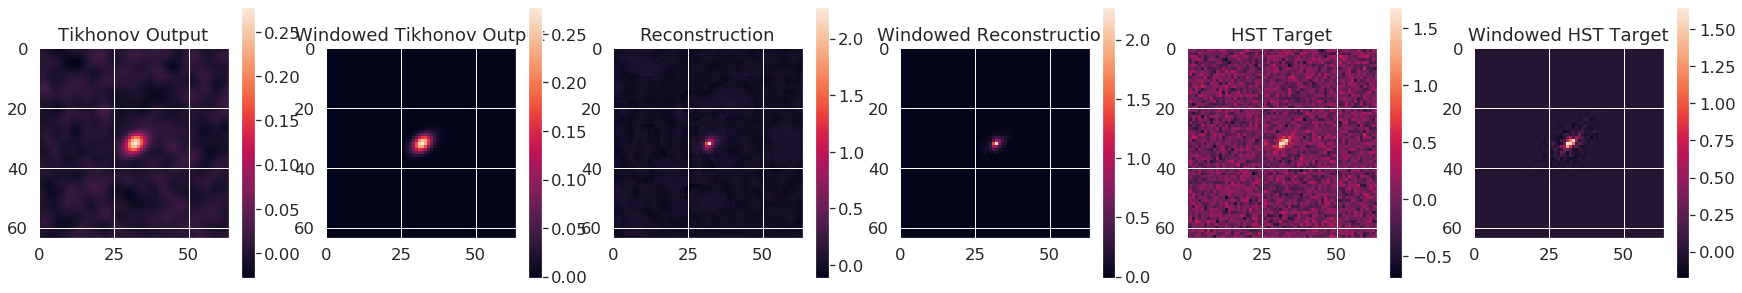

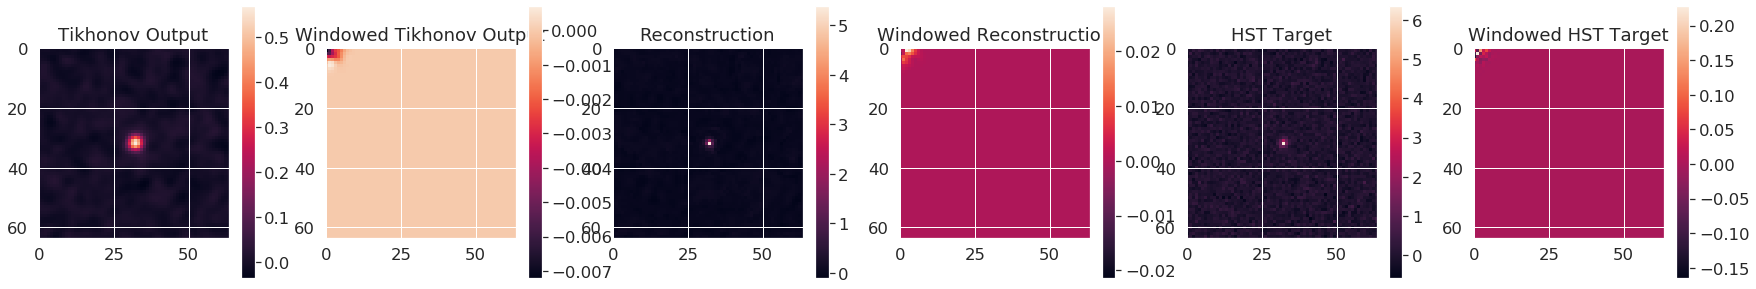

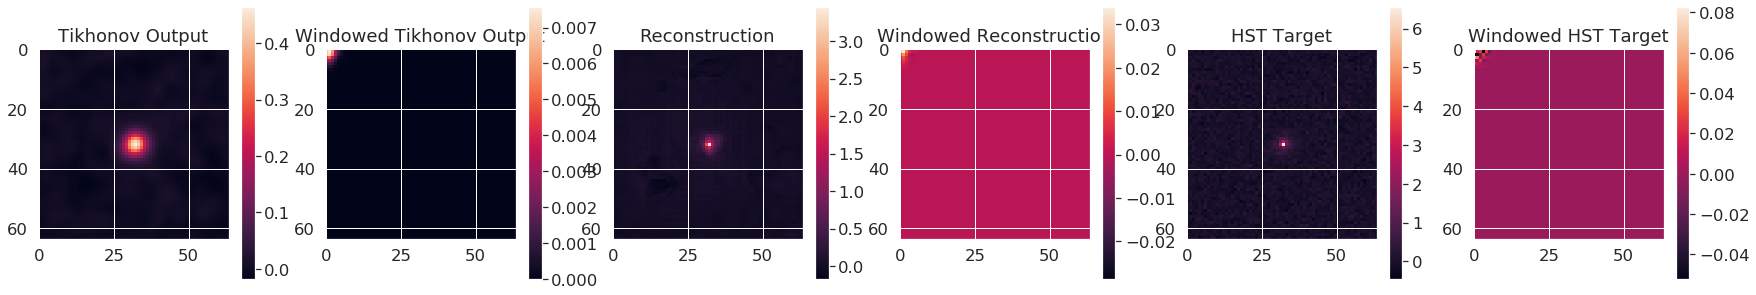

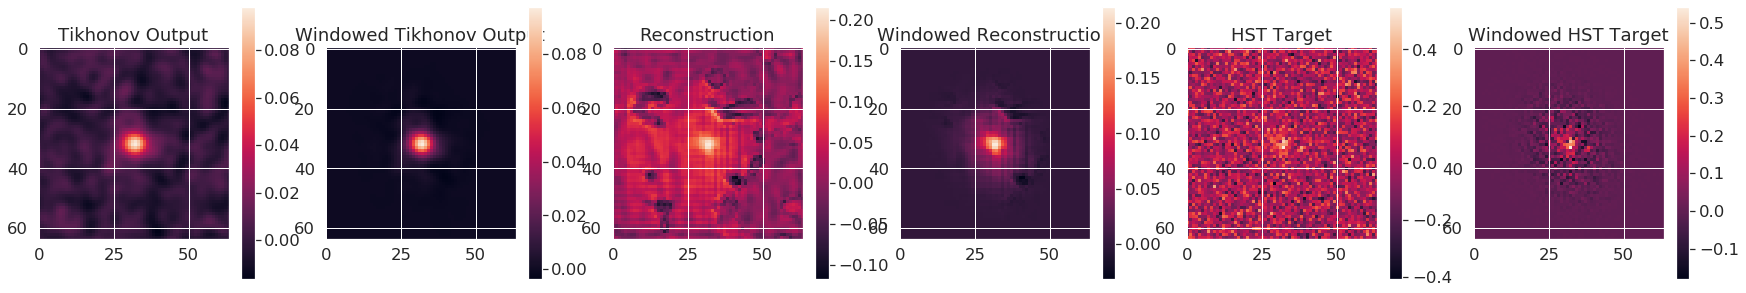

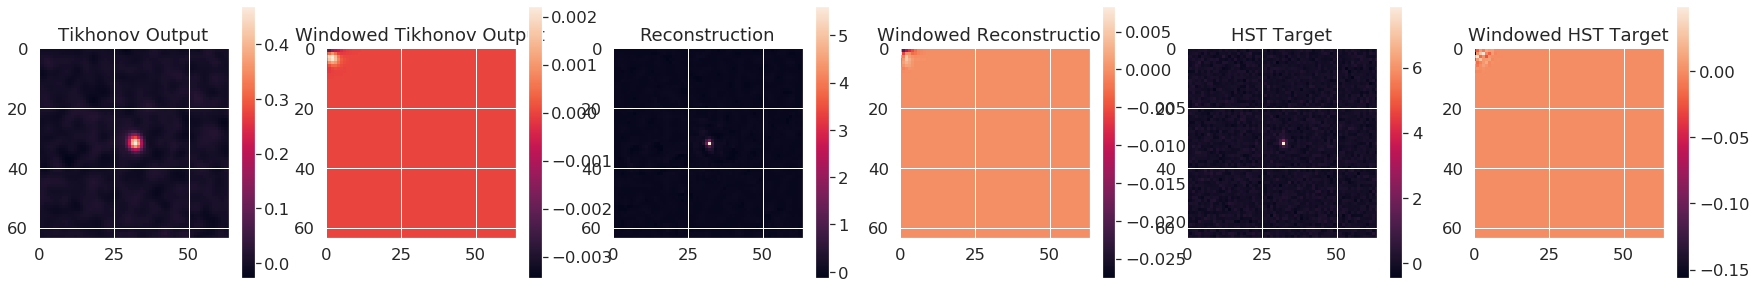

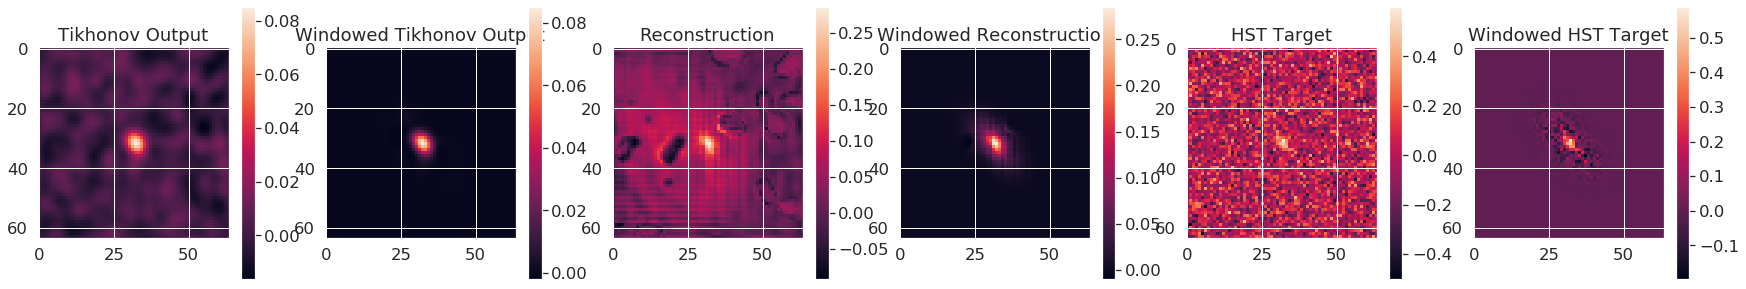

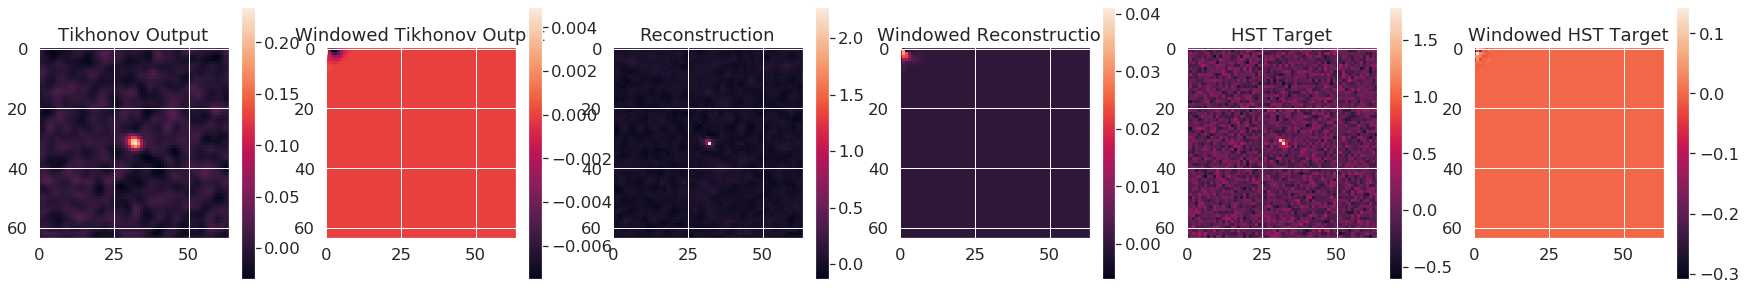

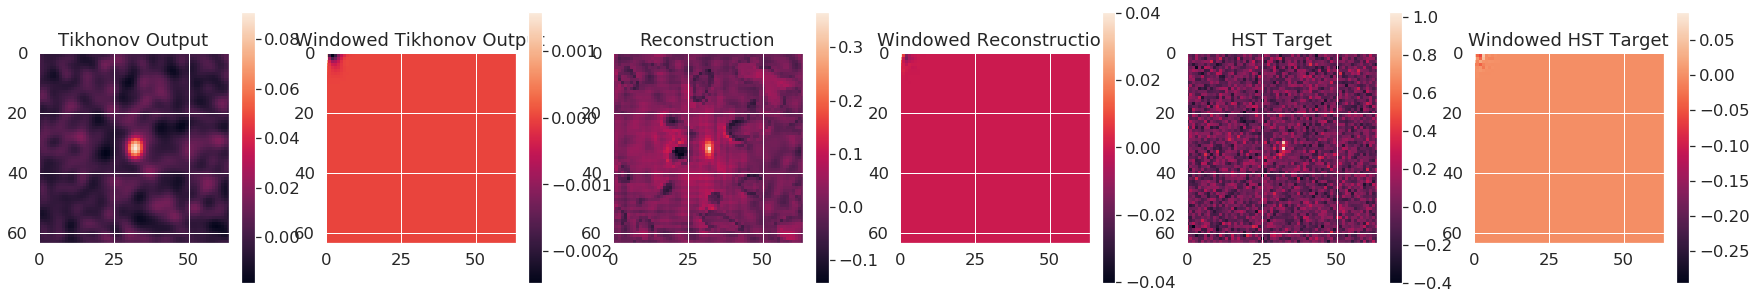

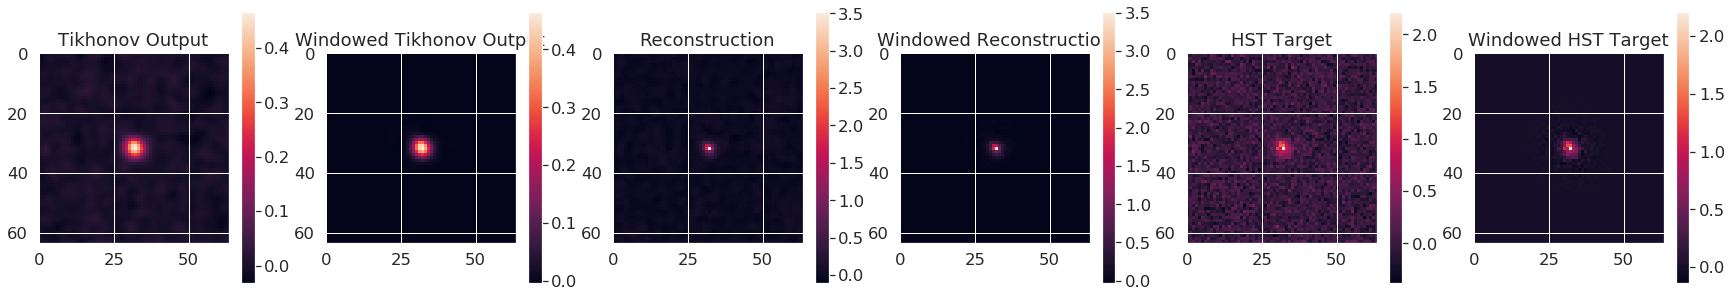

In [14]:
for i in range(20):#n_batch):
    plt.figure(33,figsize=(30,5))
    plt.subplot(161)
    plt.imshow(batch['inputs_tikho'][i])
    plt.title('Tikhonov Output')
    plt.colorbar()
    plt.subplot(162)
    plt.imshow(batch['inputs_tikho'][i]*windows[i])
    plt.title('Windowed Tikhonov Output')
    plt.colorbar()
    plt.subplot(163)
    plt.imshow(res_np[i])
    plt.title('Reconstruction')
    plt.colorbar()
    plt.subplot(164)
    plt.imshow(res_np[i]*windows[i])
    plt.title('Windowed Reconstruction')
    plt.colorbar()
    plt.subplot(165)
    plt.imshow(batch['targets'][i])
    plt.title('HST Target')
    plt.colorbar()
    plt.subplot(166)
    plt.imshow(batch['targets'][i]*windows[i])
    plt.title('Windowed HST Target')
    plt.colorbar()
    plt.show()